In [0]:
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/train_8M.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/transactions.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/holidays_events.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/items.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/oil.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/stores.csv
# !wget https://huseinhouse-storage.s3-ap-southeast-1.amazonaws.com/reinforcement-learning/recmetrics.zip
# !unzip recmetrics.zip

In [2]:
!ls

holidays_events.csv  __MACOSX  recmetrics      sample_data  train_8M.csv
items.csv	     oil.csv   recmetrics.zip  stores.csv   transactions.csv


In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9250563546529121432, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16331647727911385919
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1053375998283979888
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14892338381
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6918256158325884891
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import tensorflow as tf
import random
sns.set()

In [0]:
items = pd.read_csv("items.csv")
holiday_events = pd.read_csv("holidays_events.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv",parse_dates=['date'])
train = pd.read_csv("train_8M.csv", nrows = 500000, parse_dates=['date'])

In [6]:
pd.read_csv("items.csv")

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1
5,105574,GROCERY I,1045,0
6,105575,GROCERY I,1045,0
7,105576,GROCERY I,1045,0
8,105577,GROCERY I,1045,0
9,105693,GROCERY I,1034,0


In [0]:
stores = train['store_nbr'].values
items = train['item_nbr'].values
reward = train['unit_sales'].values

In [8]:
encoded = LabelEncoder().fit_transform(items)
items_unique = np.unique(items)
items_unique

array([  96995,  103501,  103520, ..., 1114567, 1114749, 1118683])

In [0]:
from sklearn.model_selection import train_test_split

train_stores, test_stores, train, test = train_test_split(stores, train, test_size = 0.25, shuffle = False)

In [0]:
from collections import deque
import random

In [0]:
tf.reset_default_graph()

In [13]:
LEARNING_RATE = 1e-5
LAYER_SIZE = 256
OUTPUT_SIZE = np.unique(items).shape[0]
STATE_SIZE = np.unique(stores).shape[0]

class Model:
  def __init__(self):
    self.X = tf.placeholder(tf.int32, [None])
    self.Y = tf.placeholder(tf.float32, [None, OUTPUT_SIZE])
    self.memory = deque(maxlen = 1000)
    
    self.gamma = 0.95
    self.epsilon = 0.5
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.999
        
    embeddings = tf.Variable(tf.random_uniform([STATE_SIZE, LAYER_SIZE], -1, 1))
    embedded = tf.nn.embedding_lookup(embeddings, self.X)
    feed_forward = tf.layers.dense(embedded, LAYER_SIZE, activation = tf.nn.tanh)
    self.logits = tf.layers.dense(feed_forward, OUTPUT_SIZE)
    # calculate error distance between `t` Q values with `t + 1` Q values
    self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
    self.optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(
        self.cost
    )
    self.sess = tf.InteractiveSession()
    self.sess.run(tf.global_variables_initializer())
    
  def act(self, state):
    # if random lower than epsilon, make the model explore
    if random.random() <= self.epsilon:
      return np.random.randint(OUTPUT_SIZE, size = (len(state)))
    # else, return actions from the neural network
    return np.argmax(
        self.sess.run(self.logits, feed_dict = {self.X: state}), axis = 1
    )
  
  def replay(self, batch_size):
    mini_batch = random.sample(self.memory, batch_size)
    replay_size = len(mini_batch)
    X = np.empty((replay_size))
    Y = np.empty((replay_size, OUTPUT_SIZE))
    # 0 is `t` state
    # 1 is action, item_nbr
    # 2 is reward
    # 3 is `t + 1` state
    # 4 is terminal
    states = np.array([a[0] for a in mini_batch])
    new_states = np.array([a[3] for a in mini_batch])
    Q = self.sess.run(self.logits, feed_dict = {self.X: states})
    Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
    for i in range(len(mini_batch)):
        state, action, reward, next_state, done = mini_batch[i]
        target = Q[i]
        target[action] = reward
        if not done:
            target[action] += self.gamma * np.amax(Q_new[i])
        X[i] = state
        Y[i] = target
    cost, _ = self.sess.run(
        [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
    )
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay
    return cost
  
model = Model()

W0726 03:55:33.162659 140718834829184 deprecation.py:323] From <ipython-input-13-b6e739459d82>:19: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0726 03:55:33.168240 140718834829184 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
model.sess.run(model.logits, feed_dict = {model.X: train_stores[:10]}).shape

(10, 1607)

In [15]:
train_pivoted = train.pivot_table(index='store_nbr', columns='item_nbr', values='unit_sales').fillna(0)
train_pivoted

item_nbr,96995,103501,103520,103665,105574,105575,105576,105577,105693,105737,105857,106716,108079,108696,108698,108701,108786,108797,108831,108833,108862,108952,111223,111397,112830,114778,114790,114799,114800,115267,115611,115693,115720,115847,115850,115891,115892,115893,115894,116017,...,1098624,1099990,1101724,1102268,1102970,1102971,1102975,1102976,1104598,1104599,1104650,1104725,1105210,1105211,1105212,1105213,1105214,1105215,1105228,1105299,1105831,1106968,1109116,1109173,1109211,1109235,1109325,1109326,1109389,1109390,1109391,1110679,1111202,1112839,1112840,1113847,1113852,1113872,1114749,1118683
store_nbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.000000,2.714286,2.666667,5.400000,8.000000,0.000000,2.300000,1.500000,2.888889,5.777778,1.750000,3.333333,2.125000,2.666667,2.375000,2.300000,1.888889,15.145375,0.000000,3.000000,2.500000,4.600000,11.000000,2.250000,8.300000,5.222222,1.000000,9.800000,3.250000,24.000000,3.000000,2.888889,8.250000,2.142857,4.200000,10.500000,10.750000,11.555556,9.700000,...,0.000000,0.000000,3.000000,3.000000,1.857143,1.500000,1.000000,2.857143,8.500000,3.333333,1.000000,4.000000,1.600000,13.600000,24.600000,14.500000,2.000000,0.0,2.500000,3.500000,0.000000,0.0,2.000000,0.000000,0.000000,6.5100,20.000000,2.333333,2.600000,2.000000,2.750000,0.000000,0.00,0.0,0.0,2.250000,4.428571,0.000000,1.000000,1.500000
2,2.0,0.000000,4.142857,6.333333,9.600000,9.222222,0.000000,3.000000,2.000000,4.666667,12.500000,6.200000,2.000000,3.100000,4.500000,2.700000,3.400000,9.800000,34.110222,0.000000,1.000000,3.375000,19.300000,0.000000,4.600000,5.600000,6.600000,1.000000,16.600000,8.600000,24.100000,2.000000,5.400000,4.714286,9.900000,4.111111,12.900000,14.900000,17.500000,21.700000,...,0.000000,0.000000,15.500000,3.777778,1.333333,2.833333,3.000000,4.200000,3.777778,3.400000,0.000000,16.600000,3.200000,6.000000,13.000000,0.000000,3.500000,0.0,2.833333,5.800000,1.000000,0.0,1.857143,0.000000,0.000000,0.0000,14.444444,7.800000,6.777778,4.555556,3.428571,0.000000,0.00,0.0,0.0,4.750000,2.700000,0.000000,2.750000,1.500000
3,0.0,0.000000,9.400000,11.900000,25.600000,14.300000,0.000000,5.400000,3.000000,6.700000,28.600000,8.400000,2.000000,7.000000,9.400000,0.000000,5.700000,13.900000,92.275300,0.000000,3.700000,7.500000,15.666667,37.666667,8.900000,24.200000,22.600000,3.111111,15.200000,11.300000,49.300000,7.000000,5.555556,9.222222,5.777778,9.100000,37.200000,42.200000,41.500000,36.300000,...,0.000000,5.000000,4.500000,12.625000,4.100000,3.222222,4.777778,7.888889,20.900000,8.900000,2.000000,4.125000,6.400000,57.200000,48.500000,6.800000,16.200000,0.0,4.900000,11.500000,0.000000,0.0,2.666667,2.750000,0.000000,0.0000,21.375000,8.714286,6.250000,7.555556,6.888889,0.000000,2.00,0.0,0.0,15.555556,13.700000,0.000000,5.900000,3.500000
4,2.0,0.000000,3.166667,5.125000,9.700000,18.700000,0.000000,4.000000,1.857143,3.100000,6.400000,5.800000,0.000000,2.300000,5.400000,0.000000,6.375000,7.500000,22.278333,0.000000,1.800000,4.333333,20.300000,1.000000,3.200000,10.000000,9.000000,1.125000,12.700000,7.500000,11.200000,1.571429,8.000000,4.625000,11.300000,3.800000,14.000000,15.200000,17.600000,15.200000,...,0.000000,5.625000,2.600000,5.777778,1.500000,0.000000,3.111111,3.100000,8.400000,4.777778,0.000000,5.000000,2.500000,6.000000,9.100000,0.000000,4.200000,0.0,2.666667,2.888889,0.000000,0.0,2.666667,0.000000,0.000000,7.4390,14.600000,12.000000,7.800000,8.000000,6.900000,0.000000,1.00,0.0,0.0,3.250000,2.750000,0.000000,3.000000,1.000000
5,0.0,0.000000,3.000000,6.600000,16.000000,19.500000,0.000000,9.900000,9.600000,4.750000,4.900000,3.700000,1.000000,3.400000,1.500000,3.875000,4.400000,6.700000,12.814100,0.000000,1.200000,3.750000,11.900000,0.000000,1.833333,0.000000,23.900000,2.200000,10.400000,9.300000,24.700000,1.666667,5.500000,2.333333,11.200000,3.000000,3.700000,0.000000,8.500000,16.300000,...,0.000000,2.750000,0.000000,7.142857,1.500000,1.714286,2.222222,1.857143,9.100000,3.50

In [16]:
from tqdm import tqdm
epoch = 5
batch_size = 128

for e in range(epoch):
  pbar = tqdm(
      range(0, len(train_stores) - 1, batch_size), desc = 'train minibatch loop'
    )
  loss = []
  for i in pbar:
    index = min(i + batch_size, len(train_stores) - 1)
    state = train_stores[i: index]
    action = model.act(state)
    next_state = train_stores[i + 1: index + 1]
    for no, a in enumerate(action):
      if a >= train_pivoted.shape[1]:
        r = 0
      else:
        r = train_pivoted.loc[train_stores[i + no]].iloc[a]
      model.memory.append((state[no], a, r, next_state[no], r  < 1))
    cost = model.replay(min(batch_size, len(model.memory)))
    pbar.set_postfix(cost = cost)
    loss.append(cost)
  print('\nepoch: %d, average lost: %f'%(e + 1, np.mean(loss)))

train minibatch loop:   0%|          | 4/2930 [00:00<01:24, 34.66it/s, cost=3.73e+5]


epoch: 1, average lost: 6621638.500000


train minibatch loop:   0%|          | 4/2930 [00:00<01:24, 34.46it/s, cost=1.69e+5]


epoch: 2, average lost: 1708563.000000


train minibatch loop:   0%|          | 4/2930 [00:00<01:24, 34.80it/s, cost=1.48e+6]


epoch: 3, average lost: 1601518.125000


train minibatch loop:   0%|          | 4/2930 [00:00<01:33, 31.14it/s, cost=9e+4]   


epoch: 4, average lost: 1274179.875000


train minibatch loop: 100%|██████████| 2930/2930 [01:25<00:00, 34.09it/s, cost=7.45e+4]



epoch: 5, average lost: 1458632.750000


In [17]:
test_cp = test.copy().groupby('store_nbr')['item_nbr'].agg({'actual': (lambda x: list(set(x)))})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [0]:
def get_users_predictions(user_id, n):
  p = model.sess.run(model.logits, feed_dict = {model.X: [user_id]})[0]
  p = p.argsort()[-n:][::-1]
  return [items_unique[i] for i in p]

In [19]:
recs = []
for user in test_cp.index:
    cf_predictions = get_users_predictions(user + 1, 30)
    recs.append(cf_predictions)
        
test_cp['cf_predictions'] = recs
test_cp.head()

,actual,cf_predictions
store_nbr,,
1,"[174081, 1058820, 862213, 819206, 460804, 8192...","[220435, 829389, 839362, 645294, 464374, 57563..."
2,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 645294, 839362, 828632, 12929..."
3,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 839362, 645294, 464374, 20851..."
4,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 839362, 645294, 464374, 20851..."
5,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 645294, 839362, 129296, 82863..."


In [0]:
popularity_recs = train.item_nbr.value_counts().head(30).index.tolist()

In [0]:
recs = []
for user in test_cp.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)

In [22]:
test_cp['pop_predictions'] = recs
test_cp.head()

,actual,cf_predictions,pop_predictions
store_nbr,,,
1,"[174081, 1058820, 862213, 819206, 460804, 8192...","[220435, 829389, 839362, 645294, 464374, 57563...","[222879, 314384, 559870, 564533, 502331, 27352..."
2,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 645294, 839362, 828632, 12929...","[222879, 314384, 559870, 564533, 502331, 27352..."
3,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 839362, 645294, 464374, 20851...","[222879, 314384, 559870, 564533, 502331, 27352..."
4,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 839362, 645294, 464374, 20851...","[222879, 314384, 559870, 564533, 502331, 27352..."
5,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 645294, 839362, 129296, 82863...","[222879, 314384, 559870, 564533, 502331, 27352..."


In [0]:
recs = []
for user in test_cp.index:
    random_predictions = train.item_nbr.sample(30).values.tolist()
    recs.append(random_predictions)

In [24]:
test_cp['random_predictions'] = recs
test_cp.head()

,actual,cf_predictions,pop_predictions,random_predictions
store_nbr,,,,
1,"[174081, 1058820, 862213, 819206, 460804, 8192...","[220435, 829389, 839362, 645294, 464374, 57563...","[222879, 314384, 559870, 564533, 502331, 27352...","[627885, 1089820, 1021281, 633977, 888682, 938..."
2,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 645294, 839362, 828632, 12929...","[222879, 314384, 559870, 564533, 502331, 27352...","[318847, 949297, 518091, 271479, 464906, 10895..."
3,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 839362, 645294, 464374, 20851...","[222879, 314384, 559870, 564533, 502331, 27352...","[165705, 115267, 169104, 215327, 458029, 10054..."
4,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 839362, 645294, 464374, 20851...","[222879, 314384, 559870, 564533, 502331, 27352...","[898656, 268446, 802832, 1084437, 476261, 1224..."
5,"[174081, 460804, 862213, 819206, 1058820, 8192...","[220435, 829389, 645294, 839362, 129296, 82863...","[222879, 314384, 559870, 564533, 502331, 27352...","[870545, 982727, 315178, 1084882, 1062926, 472..."


In [0]:
actual = test_cp.actual.values.tolist()
cf_predictions = test_cp.cf_predictions.values.tolist()
pop_predictions = test_cp.pop_predictions.values.tolist()
random_predictions = test_cp.random_predictions.values.tolist()

In [26]:
import recmetrics

pop_mark = []
for K in np.arange(1, 31):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.000984488736644838,
 0.001968977473289676,
 0.0029534662099345134,
 0.003937954946579352,
 0.004922443683224189,
 0.005906932419869027,
 0.006891421156513865,
 0.007875909893158704,
 0.008860398629803541,
 0.009844887366448379,
 0.010829376103093216,
 0.011813864839738054,
 0.012772130258608726,
 0.01375474590112684,
 0.014737486416586733,
 0.01572033619587069,
 0.01670328238441116,
 0.01768631427006855,
 0.018669422832093687,
 0.01965260040284982,
 0.02063584041007684,
 0.02161913717773194,
 0.02260248577012573,
 0.02358588186852998,
 0.024569321672463843,
 0.02555280181996352,
 0.02653631932261673,
 0.027519871512198205,
 0.028503455996506003,
 0.02946992619792526]

In [27]:
random_mark = []
for K in np.arange(1, 31):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0008165092901869747,
 0.0014928158192631965,
 0.0020793740173800125,
 0.002680016197955651,
 0.003268273293115812,
 0.0038845447236907256,
 0.00437117538035509,
 0.004985638865240841,
 0.005570530461345576,
 0.006087447110815575,
 0.0067247223546132535,
 0.007326289368595202,
 0.007933402023392752,
 0.008488395662652044,
 0.009025277688953564,
 0.009594678712981976,
 0.010153190437675258,
 0.010723947021334163,
 0.011299323983431548,
 0.011829294874733573,
 0.012453695857681963,
 0.013022812660444139,
 0.013567726649291057,
 0.014106227380206312,
 0.01468811080762803,
 0.015171104422532803,
 0.015648482800967162,
 0.016225637457291643,
 0.0167678968096919,
 0.017398626775056453]

In [28]:
cf_mark = []
for K in np.arange(1, 31):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.0009171871979613802,
 0.0017451571513858186,
 0.002443608822165774,
 0.0033026793307013996,
 0.004126005245938665,
 0.00487254011515213,
 0.005710444372707149,
 0.006462833253820886,
 0.007232486605511234,
 0.008011047701593926,
 0.008854385768812825,
 0.009675531863988814,
 0.010493541079283892,
 0.01133758026941455,
 0.012182730172133617,
 0.013052423470567122,
 0.013841158113105757,
 0.014702081413472637,
 0.01555421616450839,
 0.01639900878284648,
 0.01719153619347212,
 0.018038515844827675,
 0.01892270501657759,
 0.01978688005947853,
 0.0206281845278144,
 0.021458429604682704,
 0.022303958854184503,
 0.023077576133087533,
 0.023886469633535138,
 0.02469743147019663]

In [0]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,30+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter qlearning']

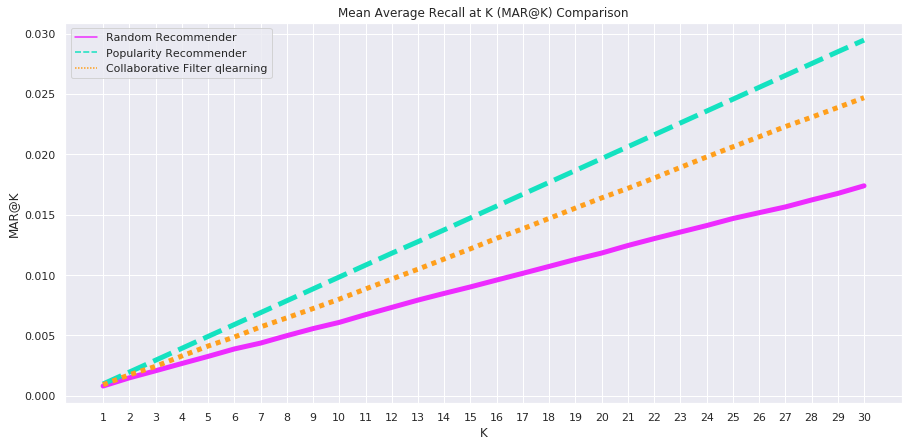

In [30]:
fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [0]:
catalog = train.item_nbr.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

In [0]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter deep-Q']

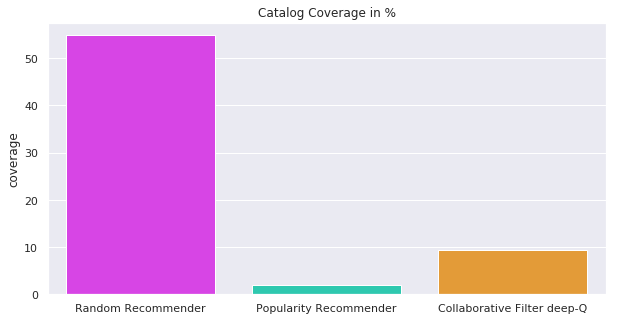

In [33]:
fig = plt.figure(figsize=(10, 5))
recmetrics.coverage_plot(coverage_scores, model_names)